In [1]:
from prepocessing import DataProcessor

In [2]:
Processor = DataProcessor()
X_train, X_test, y_train, y_test = Processor.get_datas()

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
from Modello import model
from Training import training
from Testing import testing

In [6]:
from sklearn.model_selection import KFold

In [7]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [8]:
X=X_train
y=y_train

In [9]:
accuracy=[]
for train_index, val_index in kf.split(X_train):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Creare un nuovo modello per ogni fold
    model1=model(num_k=[32,64], k_size=[3,3], p_size=[4,4], num_n=128)
    training1=training(model=model1.model,X_train=X_train,y_train=y_train, val_split=0.1, val_data=(X_val, y_val), ep=5, b_size=32, val_split=0.1)
    testing1=testing(X_val, y_val, training1)
    accuracy.append[testing1.test_accuracy]

print(accuracy)

SyntaxError: keyword argument repeated: val_split (1801277861.py, line 8)

In [19]:
model_1=model(num_k=[32,64], k_size=[3,3], p_size=[4,4], num_n=128)
training_1=training(model=model_1.model,X_train=X_train,y_train=y_train, ep=20, b_size=32, val_split=0.1)

Epoch 1/20


c:\Users\curci\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1466 - loss: 2.8186 - val_accuracy: 0.5444 - val_loss: 1.3837
Epoch 2/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5912 - loss: 1.2102 - val_accuracy: 0.7806 - val_loss: 0.6967
Epoch 3/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7576 - loss: 0.6930 - val_accuracy: 0.8926 - val_loss: 0.3961
Epoch 4/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8566 - loss: 0.4368 - val_accuracy: 0.9458 - val_loss: 0.2305
Epoch 5/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9116 - loss: 0.2783 - val_accuracy: 0.9677 - val_loss: 0.1459
Epoch 6/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9497 - loss: 0.1742 - val_accuracy: 0.9863 - val_loss: 0.0854
Epoch 7/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9655 - loss: 0.1249 - val_accuracy: 0.9936 - val_loss: 0.0489
Epoch 8/20
618/618 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9780 - loss: 0.0891 - val_accuracy: 0.9968 - val_

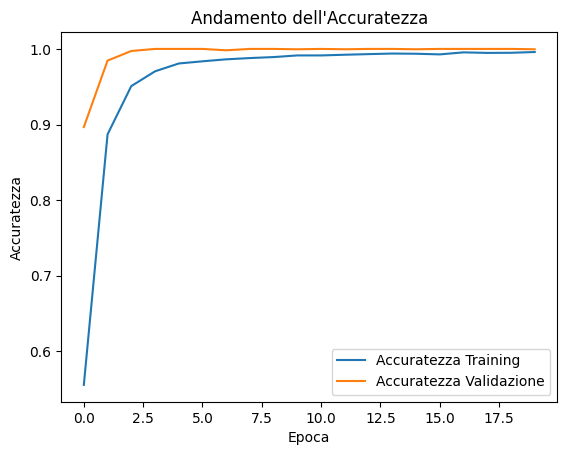

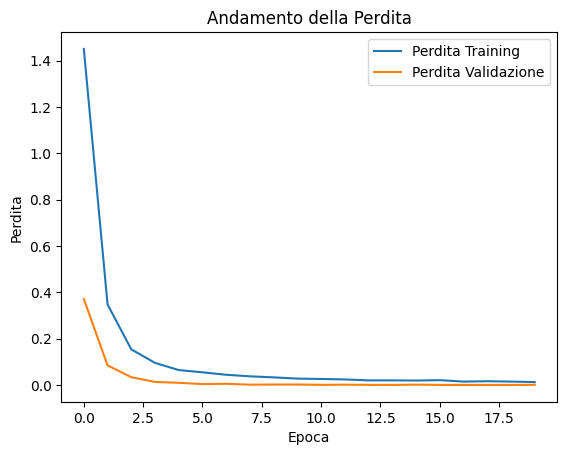

In [17]:
training_1.grafico_accuracy()
training_1.grafico_loss()

In [6]:
from Testing import testing

In [18]:
testing_1=testing(model=training_1.trained_model, X_test=X_test, y_test=y_test)
print(testing_1.test_loss, testing_1.test_accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9054 - loss: 0.4606
0.43606844544410706 0.9110429286956787
